In [4]:
from dotenv import load_dotenv
load_dotenv("../../config/local.env")

True

In [6]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-5-nano-2025-08-07",temperature=0)

In [16]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage, AIMessage

In [20]:
k = HumanMessage(content="Tell me a joke about cats.")

In [27]:
k.model_dump()

{'content': 'Tell me a joke about cats.',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'human',
 'name': None,
 'id': None,
 'example': False}

In [28]:
SystemMessage(content="You are an expert assistant").model_dump()

{'content': 'You are an expert assistant',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'system',
 'name': None,
 'id': None}

In [30]:
RemoveMessage(id=1).model_dump()

{'content': '',
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'remove',
 'name': None,
 'id': '1'}

In [32]:
AIMessage(content="Sure! Here's a cat joke for you.").model_dump()

{'content': "Sure! Here's a cat joke for you.",
 'additional_kwargs': {},
 'response_metadata': {},
 'type': 'ai',
 'name': None,
 'id': None,
 'example': False,
 'tool_calls': [],
 'invalid_tool_calls': [],
 'usage_metadata': None}

In [33]:
# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

In [ ]:
# model.invoke(["My name is Atanu", "What is my name?"])

AIMessage(content='Your name is Atanu. I’ll call you that in this chat. If you’d prefer a different name or nickname, tell me and I’ll use it.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 298, 'prompt_tokens': 20, 'total_tokens': 318, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 256, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CPtcUdou2KptophHwEFiJRdWvfc5j', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c9d08a35-a57c-495d-8a7a-3566d48e3ad4-0', usage_metadata={'input_tokens': 20, 'output_tokens': 298, 'total_tokens': 318, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 256}})

In [37]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

In [38]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

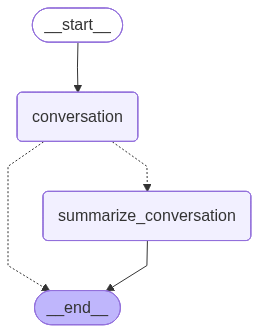

In [39]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
# workflow_ = StateGraph(State)
# workflow_.add_node("test",call_model)

# workflow_.add_edge(START, "test")
# workflow_.compile()

In [48]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nice to meet you, Lance! How can I help today? Here are a few things I can do, or feel free to tell me something specific:

- Answer questions or explain a topic
- Help with writing, editing, or brainstorming
- Plan or organize a project, trip, or schedule
- Practice a skill (coding, language, interview prep, etc.)
- Recommend books, movies, or resources

Want to share a goal or topic you’d like to dive into? I can tailor my replies to fit.


In [50]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Your name is Lance. If you’d like me to use a nickname or different form, tell me and I’ll adjust. How can I help today, Lance?


In [51]:
output

{'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='81f0ded2-324a-42f3-a784-4a779df1c1c3'),
  AIMessage(content='Nice to meet you, Lance! How can I help today? Here are a few things I can do, or feel free to tell me something specific:\n\n- Answer questions or explain a topic\n- Help with writing, editing, or brainstorming\n- Plan or organize a project, trip, or schedule\n- Practice a skill (coding, language, interview prep, etc.)\n- Recommend books, movies, or resources\n\nWant to share a goal or topic you’d like to dive into? I can tailor my replies to fit.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 691, 'prompt_tokens': 10, 'total_tokens': 701, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 576, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07

In [52]:
input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Nice! The 49ers are a solid pick and have a lot of history.

If you want, I can dive into:
- A quick overview of the franchise and its most famous eras (Bill Walsh era with Joe Montana, the 1980s dynasty, recent resurgence).
- Notable players past and present (Montana, Rice, Lott, Bosa, etc.).
- The current team, standings, and schedule (I can look up up-to-date info if you want).
- Enduring rivalries and memorable games to rewatch.
- Fantasy football notes related to 49ers players.

What would you like to hear about first?


In [57]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='81f0ded2-324a-42f3-a784-4a779df1c1c3'),
 AIMessage(content='Nice to meet you, Lance! How can I help today? Here are a few things I can do, or feel free to tell me something specific:\n\n- Answer questions or explain a topic\n- Help with writing, editing, or brainstorming\n- Plan or organize a project, trip, or schedule\n- Practice a skill (coding, language, interview prep, etc.)\n- Recommend books, movies, or resources\n\nWant to share a goal or topic you’d like to dive into? I can tailor my replies to fit.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 691, 'prompt_tokens': 10, 'total_tokens': 701, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 576, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-5-nano-2025-08-07', 'system_fin

In [58]:
input_message = HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Short answer: yes — when Nick Bosa signed his extension in 2023, it made him the highest-paid defensive player in NFL history by both total value and average annual value.

Details:
- Contract: five-year, about $170 million
- Average annual value (AAV): around $34 million per year
- Fully guaranteed at signing: roughly $122.5 million

Note: “highest paid” can mean total money, AAV, or guaranteed money. Since then, there could be new deals that change the rankings depending on which metric you care about. If you’d like, I can look up the current top defensive-player contracts to give you the latest standings. Also happy to chat about Nick Bosa’s strengths and how he impacts the 49ers' defense.


In [59]:
output

{'messages': [HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='8b114464-f4b0-4280-bb65-3f771be8fa44'),
  AIMessage(content="Short answer: yes — when Nick Bosa signed his extension in 2023, it made him the highest-paid defensive player in NFL history by both total value and average annual value.\n\nDetails:\n- Contract: five-year, about $170 million\n- Average annual value (AAV): around $34 million per year\n- Fully guaranteed at signing: roughly $122.5 million\n\nNote: “highest paid” can mean total money, AAV, or guaranteed money. Since then, there could be new deals that change the rankings depending on which metric you care about. If you’d like, I can look up the current top defensive-player contracts to give you the latest standings. Also happy to chat about Nick Bosa’s strengths and how he impacts the 49ers' defense.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'complet

In [61]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='8b114464-f4b0-4280-bb65-3f771be8fa44'),
 AIMessage(content="Short answer: yes — when Nick Bosa signed his extension in 2023, it made him the highest-paid defensive player in NFL history by both total value and average annual value.\n\nDetails:\n- Contract: five-year, about $170 million\n- Average annual value (AAV): around $34 million per year\n- Fully guaranteed at signing: roughly $122.5 million\n\nNote: “highest paid” can mean total money, AAV, or guaranteed money. Since then, there could be new deals that change the rankings depending on which metric you care about. If you’d like, I can look up the current top defensive-player contracts to give you the latest standings. Also happy to chat about Nick Bosa’s strengths and how he impacts the 49ers' defense.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1

In [62]:
graph.get_state(config).values.get("summary","")

'Summary of our conversation so far:\n\n- You introduced yourself as Lance and asked for your name; I confirmed it and offered to tailor help.\n- You mentioned you like the 49ers, and I offered several topic ideas (franchise history, notable players, current team info, etc.).\n- You said you like Nick Bosa and asked if he’s the highest-paid defensive player.\n- I responded: yes, when Bosa signed his 2023 extension he became the highest-paid defensive player in NFL history by total value and average annual value. Key details: five-year deal ~ $170 million; average annual value ~ $34 million; fully guaranteed at signing ~ $122.5 million. I also noted that “highest paid” can depend on the metric, and I offered to look up current top contracts or discuss Bosa’s strengths and impact.'

In [63]:
input_message = HumanMessage(content="Rita came to my house yesterday. She called me as Lance. Is she right?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Short answer: it depends on what you want your name to be.

- If your name is Lance (or you prefer to go by Lance) and you told Rita that, then yes—she’s correct to call you Lance.
- If your name isn’t Lance or you don’t want to be called Lance, then it’s just a mismatch and you can gently correct her.

If you want, here are quick lines you can use:
- “Hi Rita, I actually go by Lance. Please call me Lance from now on.”
- “Hi Rita, my name is [Your Real Name], I go by [Your Preferred Name]. Could you call me that?”

Want me to tailor a short message you can send her? Also, tell me what name you want to be used.


In [66]:
print(output["summary"])

Summary of our conversation so far:

- You introduced yourself as Lance and asked for your name; I confirmed it and offered to tailor help.
- You mentioned you like the 49ers, and I offered several topic ideas (franchise history, notable players, current team info, etc.).
- You said you like Nick Bosa and asked if he’s the highest-paid defensive player.
- I responded: yes, when Bosa signed his 2023 extension he became the highest-paid defensive player in NFL history by total value and average annual value. Key details: five-year deal ~ $170 million; average annual value ~ $34 million; fully guaranteed at signing ~ $122.5 million. I also noted that “highest paid” can depend on the metric, and I offered to look up current top contracts or discuss Bosa’s strengths and impact.


In [67]:
input_message = HumanMessage(content="Do I like Nick Bosa?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Yes. In your earlier message you said you like Nick Bosa and you’re a 49ers fan. If you want, I can break down what you might like about his game, his best seasons, current stats, or how he impacts the 49ers’ defense. Want a quick highlights summary or a side-by-side with other top edge rushers?


In [70]:
print(output["messages"])

[HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='8b114464-f4b0-4280-bb65-3f771be8fa44'), AIMessage(content="Short answer: yes — when Nick Bosa signed his extension in 2023, it made him the highest-paid defensive player in NFL history by both total value and average annual value.\n\nDetails:\n- Contract: five-year, about $170 million\n- Average annual value (AAV): around $34 million per year\n- Fully guaranteed at signing: roughly $122.5 million\n\nNote: “highest paid” can mean total money, AAV, or guaranteed money. Since then, there could be new deals that change the rankings depending on which metric you care about. If you’d like, I can look up the current top defensive-player contracts to give you the latest standings. Also happy to chat about Nick Bosa’s strengths and how he impacts the 49ers' defense.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16

In [71]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content="i like Nick Bosa, isn't he the highest paid defensive player?", additional_kwargs={}, response_metadata={}, id='8b114464-f4b0-4280-bb65-3f771be8fa44'),
 AIMessage(content="Short answer: yes — when Nick Bosa signed his extension in 2023, it made him the highest-paid defensive player in NFL history by both total value and average annual value.\n\nDetails:\n- Contract: five-year, about $170 million\n- Average annual value (AAV): around $34 million per year\n- Fully guaranteed at signing: roughly $122.5 million\n\nNote: “highest paid” can mean total money, AAV, or guaranteed money. Since then, there could be new deals that change the rankings depending on which metric you care about. If you’d like, I can look up the current top defensive-player contracts to give you the latest standings. Also happy to chat about Nick Bosa’s strengths and how he impacts the 49ers' defense.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1

In [72]:
input_message = HumanMessage(content="Tomorrow I will go to the park. Please remind me.")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

I can’t set real-time reminders myself, but I can help you set one up and give you ready-to-use text.

Tell me:
- What time tomorrow you plan to go to the park?
- Which device/app you use for reminders (iPhone Reminders, Google Calendar, Android, etc.)?
- Do you want multiple reminders (e.g., the night before and 30 minutes before) or just one?

In the meantime, here are ready-to-use templates you can copy-paste into your app:

Simple one-time reminder
- “Park tomorrow at [time]. Pack water, sunscreen, hat, and phone. Leave by [leave time].”

Two reminders (night before + 30 minutes before)
- Night before: “Park tomorrow at [time]. Leave by [leave time]. Pack water, sunscreen, hat.”
- 30 minutes before: “Time to head to the park. Don’t forget water and sunscreen.”

If you’re going at 5:00 PM and leaving by 4:30 PM, with a basic checklist
- Reminder 1: “Park tomorrow at 5:00 PM. Leave by 4:30 PM. Pack wate

In [75]:
print(output['summary'])

Extended summary of our conversation so far:

- You introduced yourself as Lance and asked for help with your name; I confirmed and offered to tailor assistance to your preferred name.
- You mentioned you like the 49ers, and I offered topic ideas related to Nick Bosa, the team’s history, current players, etc.
- You asked if Nick Bosa is the highest-paid defensive player; I answered yes at the time of his 2023 extension, providing contract details (five-year, ~$170M; AAV ~$34M; fully guaranteed at signing ~$122.5M) and noted that rankings depend on the metric. I also offered to look up current standings and discuss his strengths and impact.
- You asked about Rita calling you Lance after she visited yesterday; I explained naming conventions: if you go by Lance, she’s correct to call you that, and I provided sample lines to correct her if needed.
- You asked again whether you like Nick Bosa; I confirmed you do (you’re a 49ers fan) and offered to break down his game, best seasons, current 

In [77]:
graph.get_state(config).values.get("messages","")

[HumanMessage(content='Tomorrow I will go to the park. Please remind me.', additional_kwargs={}, response_metadata={}, id='fa9bff74-6d74-4b6e-96e0-69a23a88a71e'),
 AIMessage(content='I can’t set real-time reminders myself, but I can help you set one up and give you ready-to-use text.\n\nTell me:\n- What time tomorrow you plan to go to the park?\n- Which device/app you use for reminders (iPhone Reminders, Google Calendar, Android, etc.)?\n- Do you want multiple reminders (e.g., the night before and 30 minutes before) or just one?\n\nIn the meantime, here are ready-to-use templates you can copy-paste into your app:\n\nSimple one-time reminder\n- “Park tomorrow at [time]. Pack water, sunscreen, hat, and phone. Leave by [leave time].”\n\nTwo reminders (night before + 30 minutes before)\n- Night before: “Park tomorrow at [time]. Leave by [leave time]. Pack water, sunscreen, hat.”\n- 30 minutes before: “Time to head to the park. Don’t forget water and sunscreen.”\n\nIf you’re going at 5:00 P